In [1]:
from __future__ import print_function

import sys
import socket
import os

if socket.gethostname() == "qiaubuntu" or socket.gethostname() == "toologic-ubuntu2":
    repo_path = os.path.expanduser('~/repository/model_evaluation')
else:
    repo_path = os.path.expanduser('~/repo/model_evaluation')
sys.path.extend([repo_path])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import cv2
import SimpleITK as sitk
import torch
from tqdm import tqdm

import dill
import glob
from collections import OrderedDict

from datasets.data_config import get_config

%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Ready")

Ready


| Metric         | from scratch           | drn dflt augs    | drn adv augs  | unet_mc dflt | dcnn_mc dflt |unet_mc adv | dcnn_mc adv |
| :------------- |:---------------------: |:----------------:|:-------------:|:------------:|:------------:|:------------:|:------------:|
| ED-RV DSC (HD) |     0.92 (11.56)       |    0.87 (14.78)  | 0.90 (12.17)  | 0.88 (17.93) | 0.88 (14.26) | 0.88 (24.39) | 0.88 (13.61) |
| ES-RV DSC (HD) |     0.87 (11.90)       |    0.86 (13.45)  | 0.86 (12.04)  | 0.84 (19.99) | 0.85 (15.26) | 0.76 (39.37)  | 0.85 (15.32) |
| ED-LV DSC (HD) |     0.95 (7.02)        |    0.92 (12.17)  | 0.91 (11.45)  | 0.93 (12.81) | 0.93 (10.18) | 0.91 (15.06) | 0.93 (9.33) |
| ES-LV DSC (HD) |     0.92 (8.10)        |    0.85 (10.30)  | 0.83 (9.19)   | 0.88 (10.63) | 0.85 (9.39)  | 0.85 (14.66) | 0.86 (9.91) |


In [ ]:
dcnn_mc default
dice(RV/LV):	ED 0.88/0.93	
					Hausdorff(RV/LV):	ED 14.26/10.18	
dice(RV/LV):	ES 0.85/0.85	
					Hausdorff(RV/LV):	ES 15.26/9.39	

In [10]:
drn_advanced_fname = os.path.expanduser("~/expers/acdc/full/drn_advanced/results_f0_61.npz")
drn_default_fname = os.path.expanduser("~/expers/acdc/full/drn_default/results_f0_61.npz")

res_drn_advanced = dict(np.load(drn_advanced_fname))
res_drn_default = dict(np.load(drn_default_fname))

print("DSC advanced dice (RV/LV): ED {:.2f}/{:.2f}".format(res_drn_advanced['mean_dice_ed'][1],
                                                           res_drn_advanced['mean_dice_ed'][3]))
print("DSC default dice (RV/LV): ED {:.2f}/{:.2f}".format(res_drn_default['mean_dice_ed'][1],
                                                           res_drn_default['mean_dice_ed'][3]))

print("DSC advanced dice (RV/LV): ES {:.2f}/{:.2f}".format(res_drn_advanced['mean_dice_es'][1],
                                                           res_drn_advanced['mean_dice_es'][3]))
print("DSC default dice (RV/LV): ES {:.2f}/{:.2f}".format(res_drn_default['mean_dice_es'][1],
                                                           res_drn_default['mean_dice_es'][3]))

print("HD advanced dice (RV/LV): ED {:.2f}/{:.2f}".format(res_drn_advanced['mean_hd_ed'][1],
                                                           res_drn_advanced['mean_hd_ed'][3]))
print("HD default dice (RV/LV): ED {:.2f}/{:.2f}".format(res_drn_default['mean_hd_ed'][1],
                                                           res_drn_default['mean_hd_ed'][3]))

print("HD advanced dice (RV/LV): ES {:.2f}/{:.2f}".format(res_drn_advanced['mean_hd_es'][1],
                                                           res_drn_advanced['mean_hd_es'][3]))
print("HD default dice (RV/LV): ES {:.2f}/{:.2f}".format(res_drn_default['mean_hd_es'][1],
                                                           res_drn_default['mean_hd_es'][3]))

DSC advanced dice (RV/LV): ED 0.90/0.91
DSC default dice (RV/LV): ED 0.87/0.92
DSC advanced dice (RV/LV): ES 0.86/0.83
DSC default dice (RV/LV): ES 0.86/0.85
HD advanced dice (RV/LV): ED 12.17/11.45
HD default dice (RV/LV): ED 14.78/12.17
HD advanced dice (RV/LV): ES 12.04/9.19
HD default dice (RV/LV): ES 13.45/10.30


In [62]:
from datasets.common import read_nifty
from scipy.ndimage.morphology import binary_dilation, binary_opening, binary_erosion
from scipy.ndimage import generate_binary_structure

advanced_labels = os.path.expanduser("~/expers/acdc/full/drn_advanced/pred_labels/NLUTR6_23_2.nii.gz")
advanced_labels, _ = read_nifty(advanced_labels)

lv_volume = (advanced_labels[10]  == 3).astype(np.int16)
lv_volume = binary_dilation(lv_volume, iterations=1)
print(lv_volume.shape)

(15, 256, 256)


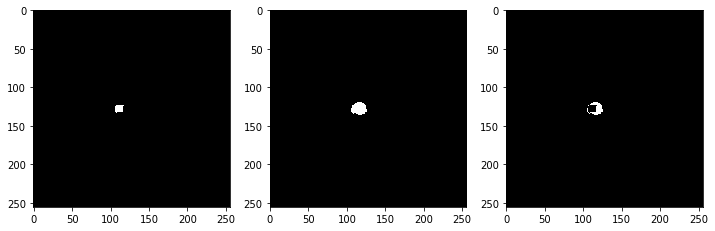

In [63]:

plt.rcParams['figure.figsize'] = [12, 10]
pred_labels_adv = advanced_labels[10, 2]

lv_slice = (pred_labels_adv == 3).astype(np.int16)
lv_dil_slice = lv_volume[2]


plt.subplot(131)
plt.imshow(lv_slice, cmap=cm.gray)
plt.subplot(132)
plt.imshow(lv_dil_slice, cmap=cm.gray)
plt.subplot(133)
plt.imshow(lv_dil_slice - lv_slice, cmap=cm.gray)
plt.show()